### importing packages

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Dropout, Flatten, Conv2D, MaxPooling2D, MaxPool2D
from keras.layers.normalization import BatchNormalization
from PIL import Image
from keras.preprocessing import image
from keras import optimizers
from keras.applications.inception_v3 import InceptionV3
from keras.applications.resnet50 import ResNet50
from keras.applications.imagenet_utils import preprocess_input
from keras import regularizers
from keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


### Setting directories

In [3]:
# setting directories
train_dir = 'input/train/'
test_dir = 'input/test/' 
train = pd.read_csv('train.csv')

### Exploring the dataset

In [4]:
# explore the data
train.head(10)                # when image contains cactus 1, otherwise 0

,id,has_cactus
0,0004be2cfeaba1c0361d39e2b000257b.jpg,1
1,000c8a36845c0208e833c79c1bffedd1.jpg,1
2,000d1e9a533f62e55c289303b072733d.jpg,1
3,0011485b40695e9138e92d0b3fb55128.jpg,1
4,0014d7a11e90b62848904c1418fc8cf2.jpg,1
5,0017c3c18ddd57a2ea6f9848c79d83d2.jpg,1
6,002134abf28af54575c18741b89dd2a4.jpg,0
7,0024320f43bdd490562246435af4f90b.jpg,0
8,002930423b9840e67e5a54afd4768a1e.jpg,1
9,00351838ebf6dff6e53056e00a1e307c.jpg,1


In [5]:
train.dtypes                  # check the data type

id            object
has_cactus     int64
dtype: object

In [6]:
train.has_cactus = train.has_cactus.apply(str)   # since the column is not about integer values, 
train.dtypes                  # change the column data type to string

id            object
has_cactus    object
dtype: object

17500
1    13136
0     4364
Name: has_cactus, dtype: int64


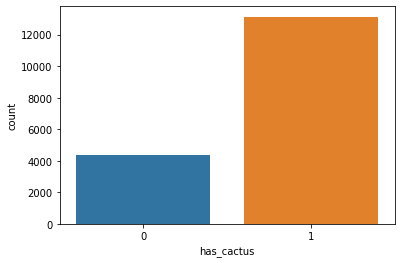

In [7]:
print(len(train))                              # number of observation: 17,500
print(train['has_cactus'].value_counts() )     # count the number of images containing cactus
sns.countplot(x='has_cactus', data=train)      # plot the output

In [8]:
# check the test dataset size
print('the number of rows in test set:', len(os.listdir(test_dir)))

the number of rows in test set: 4000


### Showing the random images

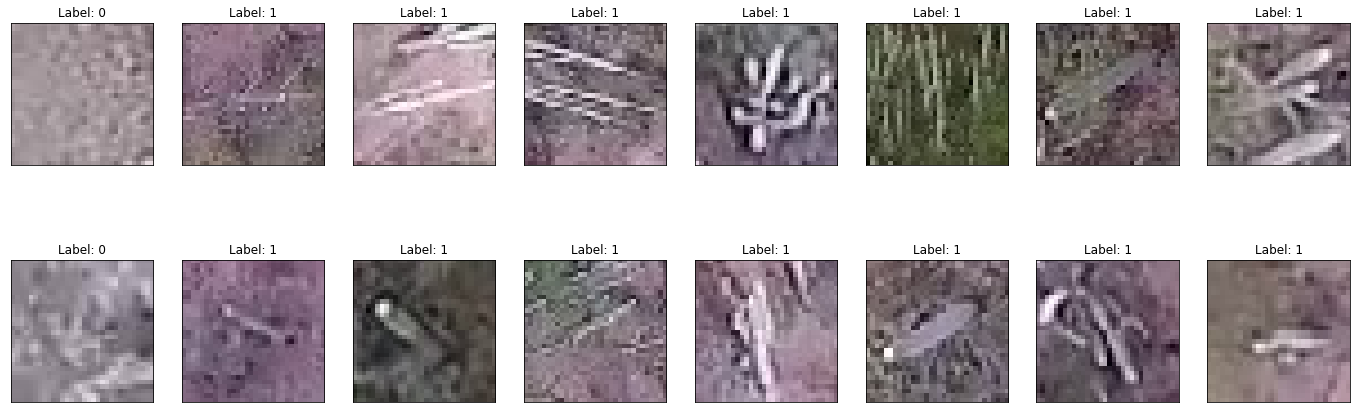

In [12]:
fig = plt.figure(figsize=(24, 8))
for idx, img in enumerate(np.random.choice(os.listdir(train_dir), 16)):
    ax = fig.add_subplot(2, 8, idx+1, xticks=[], yticks=[])
    im = Image.open(train_dir+ img)
    plt.imshow(im)
    lab = train.loc[train['id'] == img, 'has_cactus'].values[0]
    ax.set_title(f'Label: {lab}')

### Preparing the dataset

In [13]:
data = ImageDataGenerator(rescale=1./255)
batch_size = 100

<b> flow_from_dataframe method </b> can directly pass the Pandas DataFrame which has the mapping between filenames of the images and their labels. <br>
The flow_from_dataframe accepts all the arguments that flow_from_directory accepts,and obvious mandatory arguments like
- dataframe- Pandas DataFrame which contains the filenames and classes or numeric data to be treated as target values.
- directory- Path to the folder which contains all the images,None if x_col contains absolute paths pointing to each image instead of just filenames.
- x_col- The column in the dataframe that has the filenames of the images
- y_col- The column/columns in the dataframe in the filename that will be treated as raw target values if class_mode=”raw” (useful for regression tasks) or they will be treated as name of the classes if class_mode is “binary”/”categorical” or they will be ignored if class_mode is “input”/None.
- class_mode- In addition to all the class_modes previously available in flow_from_directory, there is “raw”.
- drop_duplicates- Boolean, whether to drop duplicate rows based on filename,True by default. <br>

Source: https://medium.com/@vijayabhaskar96/tutorial-on-keras-imagedatagenerator-with-flow-from-dataframe-8bd5776e45c1


In [15]:
# Split the dataset into training and validation sets
train_generator=data.flow_from_dataframe(dataframe=train[:15001],
                                         directory=train_dir,
                                         x_col='id',
                                         y_col='has_cactus',
                                         class_mode='binary',
                                         batch_size=batch_size,
                                         target_size=(150,150))

val_generator=data.flow_from_dataframe(dataframe=train[15000:],
                                         directory=train_dir,
                                         x_col='id',
                                         y_col='has_cactus',
                                         class_mode='binary',
                                         batch_size=batch_size,
                                         target_size=(150,150))

Found 15001 validated image filenames belonging to 2 classes.
Found 2500 validated image filenames belonging to 2 classes.


### Building models

In [16]:
# build a model
model = Sequential()

model.add(Conv2D(32, (3,3), activation='relu', input_shape=(150,150,3)))
model.add(MaxPool2D(2,2))
model.add(Conv2D(64, (3,3), activation='relu', input_shape=(150,150,3)))
model.add(MaxPool2D(2,2))
model.add(Conv2D(128, (3,3), activation='relu', input_shape=(150,150,3)))
model.add(MaxPool2D(2,2))
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [17]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 36992)            

In [18]:
# compile the model
model.compile(loss='binary_crossentropy', optimizer=optimizers.adam(), metrics=['acc'])

In [19]:
# train the model 
model_fit = model.fit_generator(train_generator,steps_per_epoch=100,epochs=5,
                                validation_data = val_generator,validation_steps=50)

Epoch 1/5
100/100 [==============================] - 44s 444ms/step - loss: 0.2884 - acc: 0.8922 - val_loss: 0.1555 - val_acc: 0.9128
Epoch 2/5
100/100 [==============================] - 43s 433ms/step - loss: 0.1287 - acc: 0.9523 - val_loss: 0.0665 - val_acc: 0.9756
Epoch 3/5
100/100 [==============================] - 43s 429ms/step - loss: 0.1053 - acc: 0.9623 - val_loss: 0.0988 - val_acc: 0.9700
Epoch 4/5
100/100 [==============================] - 44s 436ms/step - loss: 0.2970 - acc: 0.8974 - val_loss: 0.1262 - val_acc: 0.9520
Epoch 5/5
100/100 [==============================] - 43s 431ms/step - loss: 0.1157 - acc: 0.9562 - val_loss: 0.1684 - val_acc: 0.9680


In [20]:
# Evaluate the model 
def plot_metric(df, col, val_col, label, val_label):
    acc = df.history[col]
    epo = range(0, 5)
    plt.plot(epo, acc, label=label)
    
    val_col=df.history[val_col]
    plt.scatter(epo, val_col, label=val_label, c='red')
    plt.xlabel('# of epochs')
    plt.ylabel('Accuracy')
    plt.legend()

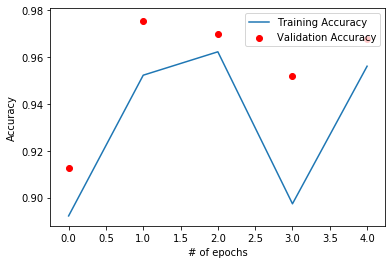

In [21]:
plot_metric(model_fit,'acc', 'val_acc','Training Accuracy', 'Validation Accuracy') 

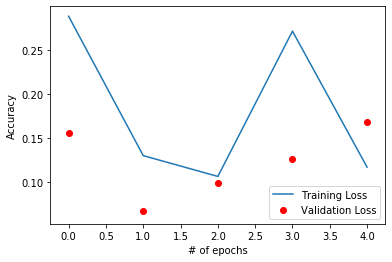

In [22]:
plot_metric(model_fit,'loss', 'val_loss','Training Loss', 'Validation Loss') 

### AlexNet

In [23]:
# Create a sequential model
alex_model = Sequential()

alex_model.add(Conv2D(filters=96, kernel_size=(11,11), strides=(4,4), padding='same',   # 1st Conv Layer
         input_shape=(150,150,3)))
alex_model.add(Activation('relu'))
alex_model.add(BatchNormalization())                                                    # used Batch Normalization(instead of LRN)
alex_model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))           # Pooling
                                             

alex_model.add(Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), padding='same'))  # 2nd Conv Layer
alex_model.add(Activation('relu'))
alex_model.add(BatchNormalization())                                                    # used Batch Normalization(instead of LRN)
alex_model.add(MaxPooling2D(pool_size=(3,3), strides=(2,2), padding='valid'))           # Pooling

alex_model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))  # 3rd Conv Layer
alex_model.add(Activation('relu'))

alex_model.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))  # 4th Conv Layer
alex_model.add(Activation('relu'))

alex_model.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))  # 5th Conv Layer
alex_model.add(Activation('relu'))

# Pass it to a dense layer
alex_model.add(Flatten())

alex_model.add(Dense(4096, input_shape=(224*224*3,)))        # 1st Dense Layer
alex_model.add(Activation('relu'))
alex_model.add(Dropout(0.5))                                 # Dropout
alex_model.add(BatchNormalization())                         # Batch Normalization

alex_model.add(Dense(4096))                                  # 2nd Dense Layer
alex_model.add(Activation('relu'))
alex_model.add(Dropout(0.5))                                 # Dropout
alex_model.add(BatchNormalization())                         # Batch Normalization

alex_model.add(Dense(1000))                                  # 3rd Dense Layer
alex_model.add(Activation('relu'))
alex_model.add(Dropout(0.5))                                 # Dropout
alex_model.add(BatchNormalization())                         # Batch Normalization

alex_model.add(Dense(1))                                     # Output Layer
alex_model.add(Activation('sigmoid'))


In [24]:
alex_model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 38, 38, 96)        34944     
_________________________________________________________________
activation_1 (Activation)    (None, 38, 38, 96)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 38, 38, 96)        384       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 18, 18, 96)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 18, 18, 256)       614656    
_________________________________________________________________
activation_2 (Activation)    (None, 18, 18, 256)       0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 18, 18, 256)      

In [25]:
# Compile the model
alex_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['acc'])

In [28]:
# Train the model
# can increase stpes_per_epoch and epcchs if you want to obtain the higher performance
alex_model_fit = alex_model.fit_generator(train_generator,steps_per_epoch=100,epochs=5,
                                 validation_data=val_generator,validation_steps=50)

Epoch 1/5
100/100 [==============================] - 75s 755ms/step - loss: 0.0836 - accuracy: 0.9685 - val_loss: 1.4253 - val_accuracy: 0.7824
Epoch 2/5
100/100 [==============================] - 76s 757ms/step - loss: 0.0684 - accuracy: 0.9747 - val_loss: 1.1613 - val_accuracy: 0.7688
Epoch 3/5
100/100 [==============================] - 75s 751ms/step - loss: 0.0946 - accuracy: 0.9767 - val_loss: 0.4852 - val_accuracy: 0.8696
Epoch 4/5
100/100 [==============================] - 75s 754ms/step - loss: 0.0629 - accuracy: 0.9770 - val_loss: 0.2820 - val_accuracy: 0.9120
Epoch 5/5
100/100 [==============================] - 75s 752ms/step - loss: 0.0426 - accuracy: 0.9844 - val_loss: 0.2940 - val_accuracy: 0.8920


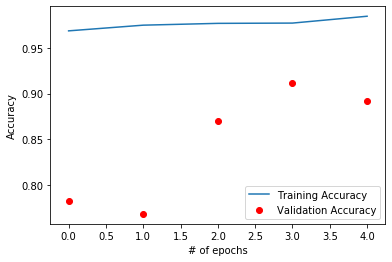

In [34]:
plot_metric(alex_model_fit,'acc', 'val_acc','Training Accuracy', 'Validation Accuracy')

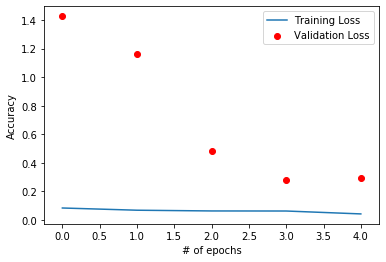

In [35]:
plot_metric(alex_model_fit,'loss', 'val_loss','Training Loss', 'Validation Loss')

### GoogLeNet - Inception V3

In [38]:
inception_model = InceptionV3(weights = "imagenet", include_top=False, input_shape = (150, 150, 3))

In [39]:
inception_model.summary()

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv2d_197 (Conv2D)             (None, 74, 74, 32)   864         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_194 (BatchN (None, 74, 74, 32)   96          conv2d_197[0][0]                 
__________________________________________________________________________________________________
activation_198 (Activation)     (None, 74, 74, 32)   0           batch_normalization_194[0][0]    
_______________________________________________________________________________________

In [40]:
# add fully connected layers with regularization 
x = inception_model.output
x = Flatten()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation="sigmoid")(x)

# create the final model 
inception_model_final =  Model(inputs=inception_model.input, outputs=predictions)

In [41]:
# compile the model
inception_model_final.compile(loss='binary_crossentropy',optimizer=optimizers.adam(),metrics=['acc'])

In [42]:
# train the model
# can increase stpes_per_epoch and epcchs if you want to obtain the higher performance
inception_model_fit = inception_model_final.fit_generator(train_generator,steps_per_epoch=100,epochs=5,
                                            validation_data=val_generator,validation_steps=50)

Epoch 1/5
100/100 [==============================] - 214s 2s/step - loss: 0.1539 - acc: 0.9620 - val_loss: 40.2493 - val_acc: 0.6492
Epoch 2/5
100/100 [==============================] - 187s 2s/step - loss: 0.0305 - acc: 0.9905 - val_loss: 0.0016 - val_acc: 0.9940
Epoch 3/5
100/100 [==============================] - 186s 2s/step - loss: 0.0161 - acc: 0.9946 - val_loss: 57.5562 - val_acc: 0.9812
Epoch 4/5
100/100 [==============================] - 188s 2s/step - loss: 0.0157 - acc: 0.9952 - val_loss: 0.0011 - val_acc: 0.9952
Epoch 5/5
100/100 [==============================] - 185s 2s/step - loss: 0.4576 - acc: 0.9518 - val_loss: 46775.0703 - val_acc: 0.2388


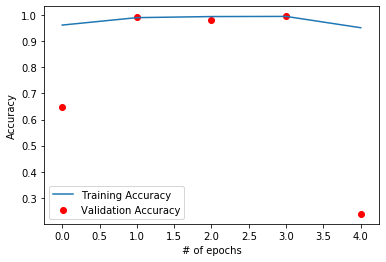

In [43]:
plot_metric(inception_model_fit,'acc', 'val_acc','Training Accuracy', 'Validation Accuracy') 

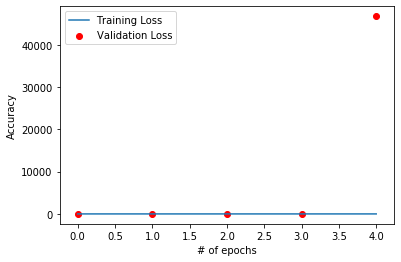

In [44]:
plot_metric(inception_model_fit,'loss', 'val_loss','Training Loss', 'Validation Loss') 

### ResNet 50

In [45]:
resnet_model = ResNet50(weights = "imagenet", include_top=False, input_shape = (150, 150, 3))

/home/dxk180020/.conda/envs/py36/lib/python3.6/site-packages/keras_applications/resnet50.py:265: UserWarning: The output shape of `ResNet50(include_top=False)` has been changed since Keras 2.2.0.
  warnings.warn('The output shape of `ResNet50(include_top=False)` '


94658560/94653016 [==============================] - 2s 0us/step


In [46]:
resnet_model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 150, 150, 3)  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 156, 156, 3)  0           input_4[0][0]                    
__________________________________________________________________________________________________
conv1 (Conv2D)                  (None, 75, 75, 64)   9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_conv1 (BatchNormalization)   (None, 75, 75, 64)   256         conv1[0][0]                      
___________________________________________________________________________________________

In [47]:
# add fully connected layers with regularization 
x = resnet_model.output
x = Flatten()(x)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation="relu")(x)
x = Dropout(0.5)(x)
predictions = Dense(1, activation="sigmoid")(x)

# create the final model 
resnet_model_final =  Model(inputs=resnet_model.input, outputs=predictions)

In [48]:
# compile the model
resnet_model_final.compile(loss='binary_crossentropy', optimizer=optimizers.adam(),metrics=['acc'])

In [49]:
# train the model
# can increase stpes_per_epoch and epcchs if you want to obtain the higher performance
resnet_model_fit= resnet_model_final.fit_generator(train_generator,steps_per_epoch=100,epochs=5,  
                                    validation_data=val_generator,validation_steps=50)

Epoch 1/5
100/100 [==============================] - 399s 4s/step - loss: 8.6421 - acc: 0.9432 - val_loss: 1714851.6250 - val_acc: 0.2520
Epoch 2/5
100/100 [==============================] - 380s 4s/step - loss: 0.0742 - acc: 0.9751 - val_loss: 20291.8281 - val_acc: 0.2520
Epoch 3/5
100/100 [==============================] - 376s 4s/step - loss: 0.5510 - acc: 0.9517 - val_loss: 5128121.5000 - val_acc: 0.2520
Epoch 4/5
100/100 [==============================] - 377s 4s/step - loss: 4.5010 - acc: 0.9283 - val_loss: 2123.1555 - val_acc: 0.2520
Epoch 5/5
100/100 [==============================] - 376s 4s/step - loss: 0.7240 - acc: 0.9504 - val_loss: 1.3001 - val_acc: 0.2592


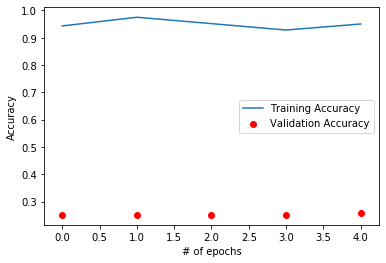

In [50]:
plot_metric(resnet_model_fit,'acc', 'val_acc','Training Accuracy', 'Validation Accuracy')

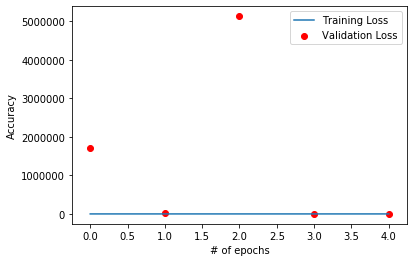

In [51]:
plot_metric(resnet_model_fit,'loss', 'val_loss','Training Loss', 'Validation Loss')

### Conclusion 

Best Model: GoogLeNet with epochs 2 considering the performance and the time (99% accuracy)

## End